# Notebook for Training Model

Importing modules and functions:

Note: always train the model using this notebook:

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.pipeline import DataPipeline
from src.model import CNN
from src.train import train_and_evaluate, plot_loss_curves

import numpy as np
import torch
import matplotlib.pyplot as plt

## Run data pipeline:

In [2]:
#Data loading and preprocessing
image_dir = '../data/npy_images'
label_path = '../data/properties/material_property.csv'
batch_size = 32
test_split = 0.1
val_split = 0.1
pipeline = DataPipeline(image_dir, label_path,batch_size, test_split, val_split)
dataloaders = pipeline.load()
train_loader = dataloaders['train']
val_loader = dataloaders['val']

## Training configure:

In [3]:
# Initialize the model, loss function, and optimizer
sample_input, _ = next(iter(train_loader))
_, c, h, w = sample_input.shape
model = CNN(input_channels=c, input_height=h, input_width=w)
loss = torch.nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

## Training:

Epoch 1/10, Train Loss: 1.0066, Val Loss: 1.0349
Epoch 2/10, Train Loss: 1.0009, Val Loss: 1.0350
Epoch 3/10, Train Loss: 0.9996, Val Loss: 1.0353
Epoch 4/10, Train Loss: 0.9557, Val Loss: 0.5389
Epoch 5/10, Train Loss: 0.1352, Val Loss: 0.0464
Epoch 6/10, Train Loss: 0.0341, Val Loss: 0.0431
Epoch 7/10, Train Loss: 0.0180, Val Loss: 0.0449
Epoch 8/10, Train Loss: 0.0177, Val Loss: 0.0124
Epoch 9/10, Train Loss: 0.0202, Val Loss: 0.0228
Epoch 10/10, Train Loss: 0.0145, Val Loss: 0.0082


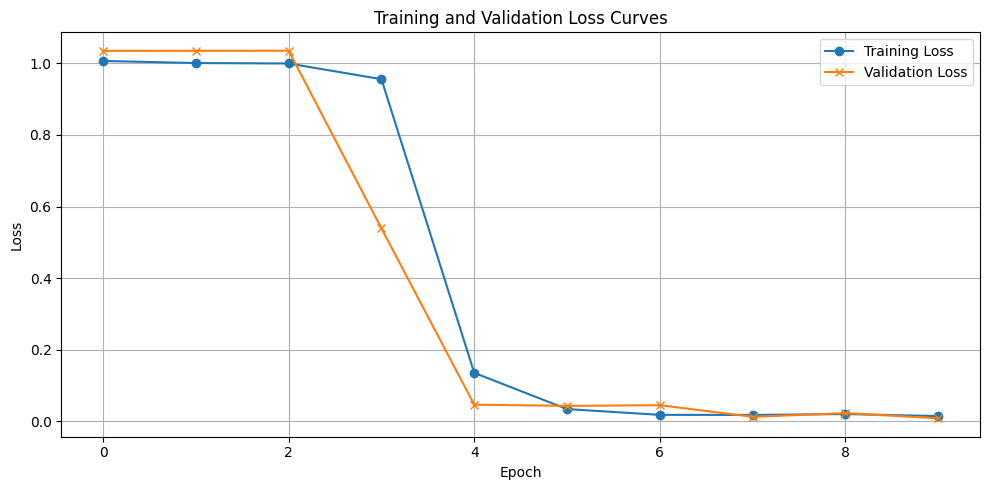

In [4]:
# Train the model
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss, optimizer, epochs=10)
# Plot training and validation loss curves
plot_loss_curves(train_losses, val_losses)

## Evaluating model for train:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X).squeeze()
        all_predictions.append(outputs.cpu())
        all_targets.append(batch_y.cpu())

    # Print first 10 predictions and targets
    sample_preds = torch.cat(all_predictions)[:10]
    sample_targets = torch.cat(all_targets)[:10]
    print("Sample predictions:\n", sample_preds)
    print("Corresponding targets:\n", sample_targets)

# Concatenate everything on CPU after inference
predictions = torch.cat(all_predictions).numpy()
y_true = torch.cat(all_targets).numpy()

# Reshape predictions to (N, 1) if they somehow became (N,)
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 1)
# Reshape y_true to (N, 1) if it's (N,)
if y_true.ndim == 1:
    y_true = y_true.reshape(-1, 1)

# Apply inverse normalization
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error and accuracy
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)
evaluation_metric = np.mean(relative_errors)

print(f"Evaluation Metric: {evaluation_metric:.2%}")
print(f"Fraction within 30% error: {accuracy_30:.2%}")

Sample predictions:
 tensor([ 0.8315,  1.1101,  1.5368, -0.7252, -0.9787, -0.3278, -0.7324, -1.3422,
        -0.2842,  0.0220])
Corresponding targets:
 tensor([ 0.7349,  0.9966,  1.8863, -0.7143, -0.9901, -0.2571, -0.7652, -1.3153,
        -0.2741,  0.0343])
[ True  True  True ...  True  True  True]
Fraction within 30% error: 100.00%


## Evaluating model for validation:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X).squeeze()
        all_predictions.append(outputs.cpu())
        all_targets.append(batch_y.cpu())

    # Print first 10 predictions and targets
    sample_preds = torch.cat(all_predictions)[:10]
    sample_targets = torch.cat(all_targets)[:10]
    print("Sample predictions:\n", sample_preds)
    print("Corresponding targets:\n", sample_targets)

# Concatenate everything on CPU after inference
predictions = torch.cat(all_predictions).numpy()
y_true = torch.cat(all_targets).numpy()

# Reshape predictions to (N, 1) if they somehow became (N,)
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 1)
# Reshape y_true to (N, 1) if it's (N,)
if y_true.ndim == 1:
    y_true = y_true.reshape(-1, 1)

# Apply inverse normalization
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error and accuracy
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)
evaluation_val_metric = np.mean(relative_errors)

print(f"Evaluation Metric: {evaluation_val_metric:.2%}")
print(f"Fraction within 30% error: {accuracy_30:.2%}")


Sample predictions:
 tensor([-0.7832,  0.5531,  1.4427,  1.3413, -0.1375, -0.7983, -0.6653, -1.3076,
        -1.2025, -1.4382])
Corresponding targets:
 tensor([-0.7451,  0.5730,  1.4814,  1.4007, -0.1853, -0.8240, -0.6205, -1.3129,
        -1.2328, -1.4048])
Fraction within 30% error: 100.00%


## Save model weights:

In [ ]:
# Define the path where you want to save the weights
DIR_PATH = '../data/models/'
MODEL_NAME = 'model_weights2.0.pth'
PATH = os.path.join(DIR_PATH, MODEL_NAME)
# Save only the state_dict
torch.save(model.state_dict(), PATH)

print(f"Model weights saved to {PATH}")